Lambda School Data Science

*Unit 4, Sprint 3, Module 3*

---

# Autoencoders

> An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner.[1][2] The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. 

## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
* <a href="#p2">Part 2</a>: Train an autoencoder
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem

__Problem:__ Is it possible to automatically represent an image as a fixed-sized vector even if it isn’t labeled?

__Solution:__ Use an autoencoder

Why do we need to represent an image as a fixed-sized vector do you ask? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already seen *representation learning* when we talked about word embedding modelings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspects of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Consider autoencoders a special case of feed-forward networks (the kind we've been studying); backpropagation and gradient descent still work. 

# Autoencoder Architecture (Learn)
<a id="p1"></a>

## Overview

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process is described simply as minimizing a loss function: 
$ L(x, g(f(x))) $

- $L$ is a loss function penalizing $g(f(x))$ for being dissimiliar from $x$ (such as mean squared error)
- $f$ is the encoder function
- $g$ is the decoder function

## Follow Along
### Extremely Simple Autoencoder

In [ ]:
# Colab Only Cell
# Remember to Switch to GPU Runtime
%tensorflow__version 2.x

In [ ]:
%load_ext tensorboard

In [119]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import glob

import numpy as np


# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
x = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoder = Dense(encoding_dim, activation='relu')(x)

# "decoded" is the lossy reconstruction of the input
decoder = Dense(784, activation='sigmoid')(encoder)

# this model maps an input to its reconstruction
autoencoder = Model(x, decoder)

In [105]:
# this model maps an input to its encoded representation


In [106]:
# create a placeholder for an encoded (32-dimensional) input

# retrieve the last layer of the autoencoder model

# create the decoder model


In [43]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [50]:
files = glob.glob('./data/quickdraw/*.npy')

In [51]:
data = {}

for f in files: 
    
    temp = np.load(f)
    drawing_type = f[17:-4]
    data[drawing_type] = temp

In [52]:
np.__version__

'1.18.2'

In [10]:
y = []
cats = {v:k for k,v in enumerate(class_names)}

for class_ in class_names:
    y_type = [cats[class_] for i in range(data[class_].shape[0])]
    y += y_type

In [11]:
for drawing_type in class_names[1:]: 
    data_all = np.concatenate((data_all,data[drawing_type]), axis=0)

In [12]:
X = data_all / 255.0
y = np.array(y)

print(X.shape[0] == len(y))

True


In [13]:
X.shape

(1595824, 784)

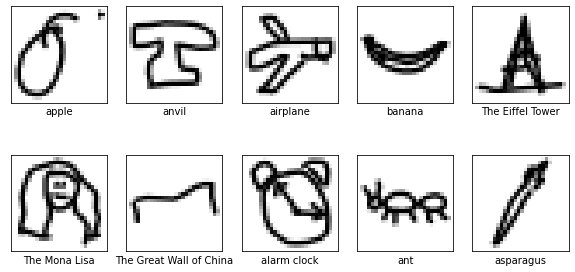

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for num, name in enumerate(class_names):
    plt.subplot(2,5, num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[name][0].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(name)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25)

In [48]:
import tensorflow as tf

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [56]:
import h5py

with h5py.File('quickdraw-sample.h5', 'w') as hf:
    hf.create_dataset("train_data", data=X_train)
    hf.create_dataset("train_labels", data=y_train)
    hf.create_dataset("test_data", data=X_test)
    hf.create_dataset("test_labels", data=y_test)

#### Callbacks

1. `EarlyStopping`
2. `TensorBoard`
3. `ModelCheckpoint`


In [27]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import os
import datetime


In [46]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))



checkpoint = ModelCheckpoint(checkpoint_dir, 
                             verbose=1, 
                             save_weights_only=True, 
                             save_freq='epoch'
                            )

stop = EarlyStopping(monitor='val_loss', 
                     patience=2, 
                     min_delta=0.001
                    )

board = TensorBoard(logdir)

callbacks = [stop,board]

autoencoder.fit(X_train, X_train,
                epochs=1000,
                batch_size=32,
                validation_data=(X_test, X_test),
                verbose = True,
                callbacks=callbacks)

Train on 1196868 samples, validate on 398956 samples
Epoch 1/1000
 278112/1196868 [=====>........................] - ETA: 41s - loss: 0.3536WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

In [31]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
%tensorboard --logdir './logs'

In [ ]:
tensorboard --log_dir='./logs'

In [101]:
# encode and decode some digits
# note that we take them from the *test* set


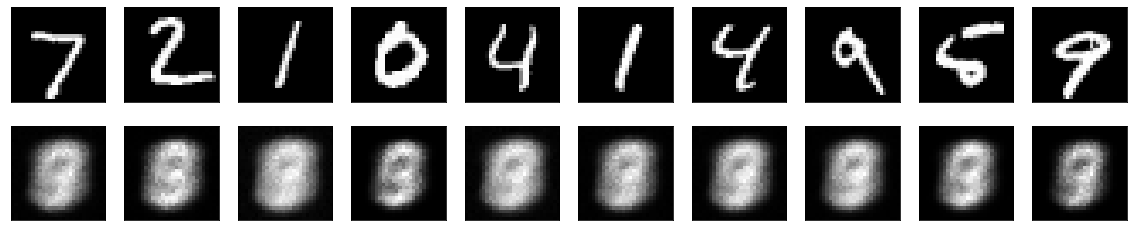

In [102]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

Expected to talk about the components of autoencoder and their purpose. 

# Train an Autoencoder (Learn)
<a id="p2"></a>

## Overview

As long as our architecture maintains an hourglass shape, we can continue to add layers and create a deeper network. 

## Follow Along

### Deep Autoencoder

In [ ]:
input_img = Input(shape=(784,))


In [ ]:
# compile & fit model

In [ ]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

> Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

# Create Model 

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [ ]:
import os
import datatime

stop = EarlyStopping(monitor=..., min_delta=0.001, patience=2)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = Tensorboard(log_dir=logdir)

autoencoder.fit(..., ...,
                epochs=10000,
                batch_size=64,
                shuffle=True,
                validation_data=(..., ...),
                verbose = False,
                callbacks=...)

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Visualization of the Representations

In [ ]:
encoder = Model(input_img, encoded)
encoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

You will train an autoencoder at some point in the near future. 

# Information Retrieval with Autoencoders (Learn)
<a id="p3"></a>

## Overview

A common usecase for autoencoders is for reverse image search. Let's try to draw an image and see what's most similiar in our dataset. 

To accomplish this we will need to slice our autoendoer in half to extract our reduced features. :) 

## Follow Along

In [94]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)

In [98]:
encoded_imgs[0].T

array([ 0.39389127,  1.0158104 ,  0.        ,  0.        ,  0.06517133,
        2.450819  ,  0.        ,  5.1117034 ,  0.74338543,  2.3620906 ,
        0.        ,  0.        ,  0.        ,  2.0215404 ,  6.1629906 ,
        0.6670714 ,  4.66508   ,  2.5439487 , 17.914988  ,  0.        ,
        7.9524546 ,  5.3824563 ,  1.0916216 ,  6.234546  ,  0.        ,
        0.8884269 ,  7.485719  ,  3.44194   ,  8.927442  ,  0.        ,
        0.23894644,  0.        ], dtype=float32)

In [99]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
nn.fit(encoded_imgs)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [ ]:
nn.kneighbors(...)

## Challenge

You should already be familiar with KNN and similarity queries, so the key component of this section is know what to 'slice' from your autoencoder (the encoder) to extract features from your data. 

# Review

* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
    - Enocder
    - Decoder
* <a href="#p2">Part 2</a>: Train an autoencoder
    - Can do in Keras Easily
    - Can use a variety of architectures
    - Architectures must follow hourglass shape
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem
    - Extract just the encoder to use for various tasks
    - AE ares good for dimensionality reduction, reverse image search, and may more things. 


# Sources

__References__
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do)

__Additional Material__